# Step 2: Data Collection & Initial EDA of Candidate Datasets
## Dataset 2: PaperDoll/Chictopia

### MLE Capstone: Outfit Recommender - Spring 2021
### By: Bazeley, Mikiko 
### GH: [@mmbazel](https://github.com/MMBazel)  

In this notebook, I'll be exploring one of three datasets (DeepFashion, Paperdoll, and iMaterialist). 

Specifically in this notebook we'll: 

☑️ Load the data

☑️ Explore the dimensions of the dataset

☑️ Understand what categories are being represented

☑️ Explore samples of the data (the meta data dictionary with catgories & attributes labels, the Train 🚂 file, and finally the images 📸 themselves)

☑️ Understand distributions of categories, attributes

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

## Explanation of the data, according to the dataset page here: 
https://github.com/kyamagu/paperdoll/tree/master/data/chictopia

### Files


### ⚠️📝 Notes (About the Notebooks) ⚠️📝 

My guiding principles:
* ➡️ Be overly communicative = While that leads to verbose commenting, I hope that means I catch a bunch of questions early)  
* ➡️ Human-readable over witty-optimization = For the most part I try to make everything I'm doing obvious
* ➡️ Write as much code as needed, and no more = There's a time and place for error-catching & object-oriented code & there are ways to make the notebook reproducible. That's not quite the goal for this notebook (or any of the other notebooks in the early stages of the project) and my goal was to write just the code needed to get this step done.  

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 1: Proper set-up & installation of necessary libraries & packages </span> 

1. Ensure you're using the right flavor of commands and that you have sqlite3 available to you. It's easy enough to pull up the terminal or whatever shell version youre using to check. 


In [1]:
#!pip3 install lmdb
#!pip3 install ipython-sql
#!brew install wget

In [2]:
##################### [TODO] SETUP #####################
# [TODO] Import any utilities functions


import json
import os
import sys
from sqlalchemy import create_engine

import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
%load_ext sql

print('Packages Imported')

modules = dir()

print(modules)
#print(os.environ)

# [TODO] Package install/load

Packages Imported
['Image', 'In', 'Out', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'create_engine', 'exit', 'get_ipython', 'io', 'json', 'lmdb', 'np', 'os', 'pd', 'plt', 'quit', 'sqlite3', 'sys']


In [3]:
# Confirm all the right libraries are present
# This is an important step because there's a good chance
# that for some pckaes where you use pip or pip3 install
# they could download to the wrong directory if you're not
# using the right pip executable

!conda list

# packages in environment at /Users/mikikobazeley/opt/anaconda3/envs/SPRINGBOARD_MLE_CAPSTONE_ENV:
#
# Name                    Version                   Build  Channel
_py-xgboost-mutex         2.0                       cpu_0  
_pytorch_select           0.1                       cpu_0    anaconda
_tflow_select             2.3.0                       mkl  
absl-py                   0.11.0             pyhd3eb1b0_1  
appnope                   0.1.2           py37hecd8cb5_1001  
argon2-cffi               20.1.0           py37haf1e3a3_1    anaconda
astor                     0.8.1            py37hecd8cb5_0  
async_generator           1.10             py37h28b3542_0    anaconda
attrs                     20.3.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    3.3.0              pyhd3eb1b0_0  
blis                      0.7.4                    pypi_0    pypi
brotlipy      

In [4]:
# Confirm path of working directory
!pwd 

/Users/mikikobazeley/Github/personal/MMBazel/Wardrobe-Recommender/notebooks/Step2_EDA


<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 2: Download the Chictopia Datasets</span> 

⚠️ Best way to not mess this process up is to follow the insteructions here exactly: https://github.com/kyamagu/paperdoll/tree/master/data/chictopia

Make sure you have installed: 
➡️ wget (I used homebrew to install & manage so it's globally available on my mac as opposed to just the conda env => !brew install wget)

## <span style='background :orange' > Clone the Github Repo </span> 

In [5]:
# Use git to clone PaperDolls repository. Note Git LFS is used to host metadata file.
# Then navigate to data/chictopia dir.
#!git clone https://github.com/kyamagu/paperdoll /Volumes/MiniGator/Projects/Datasets/Paperdoll

In [6]:
# Confirm zipfile has been downloaded to the repo
# Replace path with the path-to-dowloaded-dataset
!ls -a -F /Volumes/MiniGator/Projects/Datasets/Paperdoll

./              .git/           .gitignore*     README.md*
../             .gitattributes* LICENSE.txt*    data/


In [7]:
!ls -a -F /Volumes/MiniGator/Projects/Datasets/Paperdoll/data

./          ../         .gitignore* chictopia/


In [8]:
!ls -a -F /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia

./                  ._chictopia.sql.gz* chictopia.sql.gz*   photos/
../                 README.md*          chictopia.sqlite3*  photos.lmdb.tar*


## <span style='background :orange' > Download the image data from remote </span> 

In [9]:
# If the command doesn't work as a magic command in Jupyter; 
# run it in the vanilla terminal. 
# Download the photo data (~40GB)

#!wget https://s3-ap-northeast-1.amazonaws.com/kyamagu-public/chictopia2/photos.lmdb.tar -P /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia

In [10]:
# Check again because I'm paranoid
!ls /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos.lmdb.tar

/Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos.lmdb.tar


## <span style='background :orange' > Unzip photos file </span> 

In [11]:
# Create a directory to make sure the photos get unzipped to a specific place
#!mkdir /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos/

In [12]:
# Extract the LMDB content
# LMDB stores raw PNG binary. The key is photo id and the value is binary. 
# See the notebook demo for how to open.
# Consider using pv for tracking
# https://stackoverflow.com/questions/19372373/how-to-add-progress-bar-to-a-somearchive-tar-xz-extract
# Also: https://stackoverflow.com/questions/13707429/decompress-gzip-file-to-specific-directory

#!tar -xf /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos.lmdb.tar -C /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos/

## <span style='background :orange' > Unzip SQL file to create db, tables and load SQLite3 Chictopia DB</span> 

In [13]:
# First reconstruct the metadata SQLite3 file. 
# The following command will reconstruct the SQLite3 database file.

#!gunzip -c /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/chictopia.sql.gz | sqlite3 /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/chictopia.sqlite3

In [14]:
# Check that we see a sqlite3 file
!ls -F -a /Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/

./                  ._chictopia.sql.gz* chictopia.sql.gz*   photos/
../                 README.md*          chictopia.sqlite3*  photos.lmdb.tar*


<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 3: Use SQL to start initial exploration 🔬  </span> 

We want to understand:

☑️ What tables exist

☑️ The columns & data types for each 

☑️ Entites & relationships being captured



<span style='background :yellow' > 💡 We'll connect using the sqlite3 package & query with pandas instead of setting up the ful blown SQLAlchemy connection for the EDA. </span> 

See https://bit.ly/3r8hUC4 for the example usage notebook included with the dataset's repo.

In [15]:
#Connecting for pandas
db = sqlite3.connect('file:/Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/chictopia.sqlite3?mode=ro', uri=True)

In [16]:
# Connecting for ipyh
%sql sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3

In [17]:
# Gettin schema
schema_list = pd.read_sql("""SELECT * 
FROM sqlite_schema
""",con=db)

schema_list.sample(n=10)

type                          name         tbl_name  rootpage  \
2   table               sqlite_sequence  sqlite_sequence         4   
10  table                     bookmarks        bookmarks    120965   
41  index           index_users_on_name            users    498878   
34  index    index_taggings_on_trend_id         taggings    476962   
50  index           index_stores_on_uri           stores    523335   
44  index   index_tags_on_type_and_name             tags    501539   
12  table                      comments         comments    124514   
1   table                         users            users         3   
30  index     index_comments_on_post_id         comments    451572   
38  index  index_fanships_on_updated_at         fanships    493570   

                                                  sql  
2              CREATE TABLE sqlite_sequence(name,seq)  
10  CREATE TABLE "bookmarks" ("id" INTEGER PRIMARY...  
41  CREATE UNIQUE INDEX "index_users_on_name" ON "...  
34  CREATE INDEX "index_taggings_on_trend_id" ON "...  
50  CREATE UNIQUE INDEX "index_stores_on_uri" ON "...  
44  CREATE UNIQUE INDEX "index_tags_on_type_and_na...  
12  CREATE TABLE "comments" ("id" INTEGER PRIMARY ...  
1   CREATE TABLE "users" ("id" INTEGER PRIMARY KEY...  
30  CREATE INDEX "index_comments_on_post_id" ON "c...  
38  CREATE INDEX "index_fanships_on_updated_at" ON...

In [18]:
# Preview tables
schema_list.loc[schema_list['type'] == 'table']

type               name           tbl_name  rootpage  \
0   table  schema_migrations  schema_migrations         2   
1   table              users              users         3   
2   table    sqlite_sequence    sqlite_sequence         4   
3   table              posts              posts      6519   
4   table            streets            streets     73296   
5   table           garments           garments     73368   
6   table               tags               tags     83538   
7   table             trends             trends     84335   
8   table           fanships           fanships     86349   
9   table        friendships        friendships     93471   
10  table          bookmarks          bookmarks    120965   
11  table             stores             stores    124513   
12  table           comments           comments    124514   
13  table     color_taggings     color_taggings    318924   
14  table           taggings           taggings    322506   
15  table             photos             photos    326399   

                                                  sql  
0   CREATE TABLE "schema_migrations" ("version" va...  
1   CREATE TABLE "users" ("id" INTEGER PRIMARY KEY...  
2              CREATE TABLE sqlite_sequence(name,seq)  
3   CREATE TABLE "posts" ("id" INTEGER PRIMARY KEY...  
4   CREATE TABLE "streets" ("id" INTEGER PRIMARY K...  
5   CREATE TABLE "garments" ("id" INTEGER PRIMARY ...  
6   CREATE TABLE "tags" ("id" INTEGER PRIMARY KEY ...  
7   CREATE TABLE "trends" ("id" INTEGER PRIMARY KE...  
8   CREATE TABLE "fanships" ("id" INTEGER PRIMARY ...  
9   CREATE TABLE "friendships" ("id" INTEGER PRIMA...  
10  CREATE TABLE "bookmarks" ("id" INTEGER PRIMARY...  
11  CREATE TABLE "stores" ("id" INTEGER PRIMARY KE...  
12  CREATE TABLE "comments" ("id" INTEGER PRIMARY ...  
13  CREATE TABLE "color_taggings" ("id" INTEGER PR...  
14  CREATE TABLE "taggings" ("id" INTEGER PRIMARY ...  
15  CREATE TABLE "photos" ("id" INTEGER PRIMARY KE...

In [19]:
# Preview 10 indices
schema_list.loc[schema_list['type'] == 'index'][:10]

type                           name  tbl_name  rootpage  \
16  index       index_users_on_street_id     users    392559   
17  index         index_posts_on_user_id     posts    392956   
18  index            index_posts_on_type     posts    394661   
19  index        index_posts_on_style_id     posts    397378   
20  index     index_posts_on_occasion_id     posts    398902   
21  index       index_posts_on_season_id     posts    400450   
22  index  index_garments_on_clothing_id  garments    401805   
23  index     index_garments_on_color_id  garments    406651   
24  index     index_garments_on_brand_id  garments    411314   
25  index     index_garments_on_trend_id  garments    416255   

                                                  sql  
16  CREATE INDEX "index_users_on_street_id" ON "us...  
17  CREATE INDEX "index_posts_on_user_id" ON "post...  
18  CREATE INDEX "index_posts_on_type" ON "posts" ...  
19  CREATE INDEX "index_posts_on_style_id" ON "pos...  
20  CREATE INDEX "index_posts_on_occasion_id" ON "...  
21  CREATE INDEX "index_posts_on_season_id" ON "po...  
22  CREATE INDEX "index_garments_on_clothing_id" O...  
23  CREATE INDEX "index_garments_on_color_id" ON "...  
24  CREATE INDEX "index_garments_on_brand_id" ON "...  
25  CREATE INDEX "index_garments_on_trend_id" ON "...

In [20]:
# Schema only has ables & indices
schema_list.loc[(schema_list['type'] != 'index') & (schema_list['type'] != 'table') ]

Empty DataFrame
Columns: [type, name, tbl_name, rootpage, sql]
Index: []

In [21]:
# Now we want to start creating analytics around the tables
table_names_list = list(schema_list.loc[schema_list['type'] == 'table']['tbl_name'])

table_names_list.remove('schema_migrations')
table_names_list.remove('sqlite_sequence')

table_names_list

['users',
 'posts',
 'streets',
 'garments',
 'tags',
 'trends',
 'fanships',
 'friendships',
 'bookmarks',
 'stores',
 'comments',
 'color_taggings',
 'taggings',
 'photos']

In [22]:
# We're going to grab the tablenames and their columns
table_list_dict = {}


#Note: You cannot parameterize tablenames directly using 
# pandas read_sql
# See link: https://stackoverflow.com/questions/5870284/can-i-use-parameters-for-the-table-name-in-sqlite3
# You can however re-build the query string each time & concatenate tablename 

for t_name in table_names_list:
    query = f'SELECT * FROM {t_name} where 1=2'
    table_list_dict[t_name] = pd.read_sql(query, con=db)

In [23]:
tables_columns = {}

for t_name in table_names_list:
    tables_columns[t_name] = pd.DataFrame(table_list_dict[t_name].columns)
    
tables_columns

{'users':                              0
 0                           id
 1                         name
 2                         type
 3                    street_id
 4                        views
 5                  chic_points
 6                       status
 7                  description
 8              bookmarks_count
 9               comments_count
 10               friends_count
 11                  fans_count
 12  favorite_chictopians_count
 13                  created_at
 14                  updated_at,
 'posts':                   0
 0                id
 1      chictopia_id
 2           user_id
 3              type
 4            status
 5             votes
 6             title
 7              date
 8       description
 9          style_id
 10      occasion_id
 11        season_id
 12   comments_count
 13  bookmarks_count
 14       created_at
 15       updated_at,
 'streets':               0
 0            id
 1          name
 2  chictopia_id
 3   users_count,
 'garments':  

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 4A: 🔬 Deeper EDA & Exploration of Some of the Relationships 📚</span> 

☑️ Explore samples of the tables

* Tables = 'users','posts','streets','garments','tags','trends',
'fanships','friendships','bookmarks','stores','comments',
'color_taggings','taggings','photos'


☑️ Understand relationships

* Relationships = 
* ➡️ User-Posts-Photos relationships (1 <-> M <-> M)
* ➡️ Post-Tag relationships (M <-> M)
* ➡️ User-User (Many <-> Many)

## <span style='background :orange' > 🥨 Sample the different tables, without committing to a full load into pandas 🐼 </span>

* Link for more details: https://pypi.org/project/ipython-sql/
* Link 2: https://bit.ly/2ZZknmq

In [24]:
# Gettin sample for users table

%sql SELECT * FROM users limit 5

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 'flairtoremember', 'Styleicon', 3, 69031, 17228, 2, '<p>Aloha! I’m Nikki ~ an Australian sea-side dwelling fashion lover, vintage adorer, blogger, graphic artist, vegetarian, happiness junkie + daydream ... (202 characters truncated) ... p://flairtoremember.blogspot.com"><img src="http://i303.photobucket.com/albums/nn133/flairtoremember/FTRHeaderNov10-2.jpg" alt="Photobucket"></a></p>', 85, 1149, 1145, 1049, 12, '2012-09-07 23:05:21.106824', '2012-12-15 15:20:37.359857'),
 (2, 'karlascloset', 'Styleicon', None, 63366, 22842, 2, '<p><strong>GO HERE- <a rel="nofollow" href="http://www.karlascloset.com">karlascloset.com</a></strong></p>', 0, 108, 471, 1992, 2, '2012-09-07 23:05:21.299500', '2012-12-15 15:04:58.981998'),
 (3, 'camiller', 'Styleicon', 6, 47751, 14030, 2, '', 36, 187, 81, 975, 6, '2012-09-07 23:05:21.448243', '2012-12-15 14:56:57.263695'),
 (4, 'kirstylee', 'Styleicon', None, 39926, 7966, 2, '<p>Big hair and inappropriate shoes.</p>\n<p>Click </p>\n<p><a rel="nofollow" href="http://thatsjustmyvibe.blogspot.com" target="_blank">That’s Just  ... (90 characters truncated) ... arget="_blank">BritUgly</a></p>\n<p><a rel="nofollow" href="http://shop.ebay.co.uk/merchant/thats_just_vintage" target="_blank">My eBay Store</a></p>', 0, 60, 216, 495, 3, '2012-09-07 23:05:21.652778', '2012-12-16 05:25:39.491331'),
 (5, 'lindarrr', 'Styleicon', 5, 67730, 11792, 2, '<p><a rel="nofollow" href="http://www.chictopia.com/user/blog/CoedUgly" target="_blank">CoedUgly</a></p>', 7, 353, 585, 746, 24, '2012-09-07 23:05:21.815427', '2012-12-15 14:59:40.168670')]

In [25]:
# Gettin sample for garments table

%sql SELECT * FROM garments limit 5


 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, None, None, None, 1, None, 61),
 (2, None, None, None, 2, None, 61),
 (3, None, None, None, 3, None, 61),
 (4, None, None, None, 4, None, 61),
 (5, None, None, None, 5, None, 73)]

In [26]:
# Gettin sample for taggings table

%sql SELECT * FROM taggings limit 5

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 1, 57, '2012-09-07 23:10:14.887007', '2012-09-07 23:10:14.887007'),
 (2, 1, 58, '2012-09-07 23:10:14.999036', '2012-09-07 23:10:14.999036'),
 (3, 1, 59, '2012-09-07 23:10:15.152238', '2012-09-07 23:10:15.152238'),
 (4, 7, 62, '2012-09-07 23:10:37.215173', '2012-09-07 23:10:37.215173'),
 (5, 50, 71, '2012-09-07 23:11:37.598591', '2012-09-07 23:11:37.598591')]

In [27]:
# Gettin sample for trends table

%sql SELECT * FROM trends limit 5

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 'american eagle tee', 54409, 0, 1),
 (2, 'target shortalls', 54410, 0, 1),
 (3, 'topshop tights', 54411, 0, 1),
 (4, 'urban outfitters flats', 54412, 0, 1),
 (5, 'urban outfitters tee', 54407, 0, 1)]

In [28]:
# Gettin sample for color_taggings table

%sql SELECT * FROM color_taggings limit 5

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 5, 9), (2, 5, 10), (3, 5, 11), (4, 5, 12), (5, 13, 27)]

## <span style='background :orange' > Let's Look at Relationships & Specific Examples 🧑‍🤝‍🧑</span>

### <span style='background :yellow' > 🧑‍🤝‍🧑 Relationship: Users & Posts  </span>

In [29]:
# Users and posts
%sql SELECT * FROM posts WHERE user_id = 1234

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(59689, 133637, 1234, 'StylePost', 2, 0, 'box', '2009-07-09', '<p>http://crowdedfireblog.blogspot.com</p>', 777, 2, None, 0, 0, '2012-09-08 16:01:39.004418', '2012-12-12 03:24:18.422711')]

In [30]:
%sql SELECT user_id, count(id) FROM posts group by 1 order by 2 desc limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1434, 933),
 (1106, 915),
 (12861, 781),
 (164, 729),
 (6688, 706),
 (6684, 691),
 (13767, 656),
 (6022, 620),
 (2785, 582),
 (8720, 551)]

In [31]:
%sql select \
    count(user_id) as user_count, \
    sum(post_count) as post_count, \
    min(post_count) as min_user_post_count, \
    max(post_count) as max_user_post_count, \
    round(avg(post_count),0) as avg_user_post_count \
from (SELECT user_id, count(id) as post_count FROM posts group by 1)

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(49403, 617108, 1, 933, 12.0)]

### <span style='background :yellow' > 🧑‍🤝‍🧑 Relationship: Posts & Tags  </span>

In [32]:
%sql SELECT * FROM tags WHERE type = 'Clothing' limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(68, 'accessories', 'Clothing', 63911),
 (62, 'bag', 'Clothing', 102505),
 (65, 'belt', 'Clothing', 61683),
 (39, 'blazer', 'Clothing', 42779),
 (195, 'blouse', 'Clothing', 61927),
 (240, 'bodysuit', 'Clothing', 2430),
 (151, 'boots', 'Clothing', 83500),
 (369, 'bra', 'Clothing', 2492),
 (424, 'bracelet', 'Clothing', 25088),
 (1264, 'cape', 'Clothing', 2438)]

In [33]:
%sql SELECT distinct(type) FROM tags

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[('Brand',), ('Clothing',), ('Color',), ('Occasion',), ('Style',)]

In [53]:
%sql SELECT * \
FROM tags WHERE type = 'Brand' \
order by 4 desc limit 20

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(29, 'H&M', 'Brand', 114707),
 (45, 'Forever-21', 'Brand', 88344),
 (84, 'Zara', 'Brand', 85133),
 (56, 'vintage', 'Brand', 74970),
 (142, 'thrifted', 'Brand', 34684),
 (47, 'Topshop', 'Brand', 31182),
 (43, 'Urban-Outfitters', 'Brand', 22576),
 (40, 'Target', 'Brand', 20978),
 (87, 'American-Apparel', 'Brand', 17978),
 (540, 'Forever21', 'Brand', 17689),
 (88, 'Primark', 'Brand', 15639),
 (809, 'Mango', 'Brand', 15106),
 (341, 'asos', 'Brand', 14264),
 (802, 'Aldo', 'Brand', 12433),
 (163, 'Gap', 'Brand', 11798),
 (54, 'Old-Navy', 'Brand', 11230),
 (218, 'Steve-Madden', 'Brand', 10159),
 (994, 'thrifted-vintage', 'Brand', 9618),
 (1606, 'Bershka', 'Brand', 9165),
 (199, 'DIY', 'Brand', 8600)]

In [52]:
%sql SELECT * \
FROM tags WHERE type = 'Occasion' \
order by 4 desc limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(2, 'Everyday', 'Occasion', 230977),
 (5, 'Casual Party', 'Occasion', 27422),
 (3, 'Work', 'Occasion', 23838),
 (89, 'Dinner Date', 'Occasion', 18961),
 (6, 'Cocktail', 'Occasion', 17944),
 (77, 'Girls Night Out', 'Occasion', 17184),
 (646, 'Going Out With Friends', 'Occasion', 16774),
 (113, 'Clubbing', 'Occasion', 12921),
 (135, 'Shopping', 'Occasion', 12484),
 (419, 'Brunch', 'Occasion', 12009)]

### <span style='background :yellow' > 🧑‍🤝‍🧑 Relationship: Users & Users  </span>

In [54]:
%sql SELECT * \
FROM users \
limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 'flairtoremember', 'Styleicon', 3, 69031, 17228, 2, '<p>Aloha! I’m Nikki ~ an Australian sea-side dwelling fashion lover, vintage adorer, blogger, graphic artist, vegetarian, happiness junkie + daydream ... (202 characters truncated) ... p://flairtoremember.blogspot.com"><img src="http://i303.photobucket.com/albums/nn133/flairtoremember/FTRHeaderNov10-2.jpg" alt="Photobucket"></a></p>', 85, 1149, 1145, 1049, 12, '2012-09-07 23:05:21.106824', '2012-12-15 15:20:37.359857'),
 (2, 'karlascloset', 'Styleicon', None, 63366, 22842, 2, '<p><strong>GO HERE- <a rel="nofollow" href="http://www.karlascloset.com">karlascloset.com</a></strong></p>', 0, 108, 471, 1992, 2, '2012-09-07 23:05:21.299500', '2012-12-15 15:04:58.981998'),
 (3, 'camiller', 'Styleicon', 6, 47751, 14030, 2, '', 36, 187, 81, 975, 6, '2012-09-07 23:05:21.448243', '2012-12-15 14:56:57.263695'),
 (4, 'kirstylee', 'Styleicon', None, 39926, 7966, 2, '<p>Big hair and inappropriate shoes.</p>\n<p>Click </p>\n<p><a rel="nofollow" href="http://thatsjustmyvibe.blogspot.com" target="_blank">That’s Just  ... (90 characters truncated) ... arget="_blank">BritUgly</a></p>\n<p><a rel="nofollow" href="http://shop.ebay.co.uk/merchant/thats_just_vintage" target="_blank">My eBay Store</a></p>', 0, 60, 216, 495, 3, '2012-09-07 23:05:21.652778', '2012-12-16 05:25:39.491331'),
 (5, 'lindarrr', 'Styleicon', 5, 67730, 11792, 2, '<p><a rel="nofollow" href="http://www.chictopia.com/user/blog/CoedUgly" target="_blank">CoedUgly</a></p>', 7, 353, 585, 746, 24, '2012-09-07 23:05:21.815427', '2012-12-15 14:59:40.168670'),
 (6, 'annabel', 'Styleicon', 29, 105337, 37165, 2, '<p><a rel="nofollow" href="http://ornithes.tumblr.com/" target="_blank">TUMBLR</a></p>\n<p><a rel="nofollow" href="http://blushingambition.blogspot.com/" target="_blank">BLOG</a></p>', 47, 171, 1053, 4197, 45, '2012-09-07 23:05:21.977855', '2012-12-15 15:52:50.294407'),
 (7, 'homme', 'Styleicon', 2, 13014, 3470, 2, '<p>Hi, I’m Philip.<br><br><a rel="nofollow" href="http://www.knightyknight.com" target="_blank">www.knightyknight.com</a><br><br>\nP.S. I co-edit <a rel="nofollow" href="http://www.chictopia.com/user/blog/MaleUgly" target="_blank">MaleUgly</a>, check it out.</p>', 0, 181, 149, 58, 27, '2012-09-07 23:05:22.150241', '2012-12-16 05:25:22.500291'),
 (8, 'ClothesHorse', 'Styleicon', 28, 67217, 14535, 2, '<p>I’m a vintage and secondhand lover who likes an eccentric and eclectic mix of clothes.<br><a rel="nofollow" href="http://theclothes.blogspot.com/">The Clothes Horse blog</a></p>', 28, 1805, 1738, 2086, 18, '2012-09-07 23:05:22.312261', '2012-12-15 15:46:30.766824'),
 (9, 'the_kitten', 'Styleicon', 1, 14216, 2263, 2, '<p>All you need to know is <a rel="nofollow" href="http://www.pickedpics.blogspot.com" target="_blank">here</a> really.</p>', 0, 85, 233, 128, 6, '2012-09-07 23:05:22.474603', '2012-12-16 05:25:19.346471'),
 (10, 'Luxenoir', 'Styleicon', None, 17585, 2488, 2, '', 39, 52, 210, 164, 1, '2012-09-07 23:05:22.626346', '2012-12-16 05:25:32.495229')]

In [56]:
%sql SELECT * \
FROM friendships \
limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 9, 31, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (2, 7, 31, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (3, 31, 9, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (4, 31, 7, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (5, 9, 34, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (6, 7, 37, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (7, 34, 9, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (8, 37, 7, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (9, 9, 42, '2012-09-29 18:11:38', '2012-09-29 18:11:38'),
 (10, 7, 41, '2012-09-29 18:11:38', '2012-09-29 18:11:38')]

In [57]:
%sql SELECT * \
FROM fanships \
limit 10

 * sqlite:////Volumes//MiniGator//Projects//Datasets//Paperdoll//data//chictopia//chictopia.sqlite3
Done.


[(1, 986, 11, None, None),
 (2, 1006, 11, None, None),
 (3, 1011, 11, None, None),
 (4, 1023, 11, None, None),
 (5, 1028, 11, None, None),
 (6, 21, 11, None, None),
 (7, 1037, 11, None, None),
 (8, 1040, 11, None, None),
 (9, 1045, 11, None, None),
 (10, 1046, 11, None, None)]

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 4B: 🔬 Previewing Some Random Images 📸 </span> 

🤔 To make things easy, we'll adopt the code laid out in the example notebook 📓  in the git repo located here: https://bit.ly/3kxRN5d

📌 According to the authors:
<span style='background :yellow' ><b> Photo URL is "http://images{N}.chictopia.com" + path, where N is one of {0, 1, 2, 3}. Can be any. For example, either of the following works.
* http://images1.chictopia.com/photos/thefashbot/1930972049/1930972049_400.jpg
* http://images2.chictopia.com/photos/thefashbot/1930972049/1930972049_400.jpg </span> 


In [59]:
# This part of the code is adopted from the example_usage notebook 
# https://bit.ly/3kxRN5d
photos = pd.read_sql("""
    SELECT
        *,
        'http://images2.chictopia.com/' || path AS url
    FROM photos
    WHERE photos.post_id IS NOT NULL AND file_file_size IS NOT NULL
""", con=db)
print('photos = %d' % (len(photos)))
photos.head()

photos = 1100987


id  post_id                                               path  status  \
0   1       61   /photos/thefashbot/1930972049/1930972049_400.jpg       2   
1   2       73   /photos/thefashbot/3613535083/3613535083_400.jpg       2   
2   3       73  /photos/thefashbot/3613535083/3420751783/34207...       2   
3   4       85  /photos/thefashbot/10902372197/10902372197_400...       2   
4   5       98   /photos/thefashbot/4328323416/4328323416_400.jpg       2   

                   file_file_name  file_file_size file_content_type  \
0   open-uri20120907-29328-3yd0mp          122564        image/jpeg   
1  open-uri20120907-29328-1szdum6          119821        image/jpeg   
2  open-uri20120907-29328-1uz77bi          115073        image/jpeg   
3  open-uri20120907-29328-1nqep2j          115259        image/jpeg   
4  open-uri20120907-29328-10ax6ou          123235        image/jpeg   

              file_updated_at  width  height                  created_at  \
0  2012-09-07 23:07:38.719079    400     600  2012-09-07 23:07:38.441357   
1  2012-09-07 23:07:45.966209    400     600  2012-09-07 23:07:45.721208   
2  2012-09-07 23:07:46.825511    400     600  2012-09-07 23:07:45.785651   
3  2012-09-07 23:07:53.314908    400     600  2012-09-07 23:07:52.920956   
4  2012-09-07 23:08:00.645646    400     600  2012-09-07 23:08:00.081276   

                   updated_at  \
0  2012-09-07 23:07:39.456904   
1  2012-09-07 23:07:46.438801   
2  2012-09-07 23:07:47.722063   
3  2012-09-07 23:07:54.329817   
4  2012-09-07 23:08:01.889023   

                                                 url  
0  http://images2.chictopia.com//photos/thefashbo...  
1  http://images2.chictopia.com//photos/thefashbo...  
2  http://images2.chictopia.com//photos/thefashbo...  
3  http://images2.chictopia.com//photos/thefashbo...  
4  http://images2.chictopia.com//photos/thefashbo...

In [60]:
# This part of the code is adopted from the example_usage notebook 
# https://bit.ly/3kxRN5d

class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

In [63]:
# This part of the code is adopted from the example_usage notebook 
# https://bit.ly/3kxRN5d
# There should be 1.09 Million photos

photo_data = PhotoData('/Volumes/MiniGator/Projects/Datasets/Paperdoll/data/chictopia/photos/photos.lmdb')
print(len(photo_data))

1097474


1
http://images2.chictopia.com//photos/thefashbot/1930972049/1930972049_400.jpg


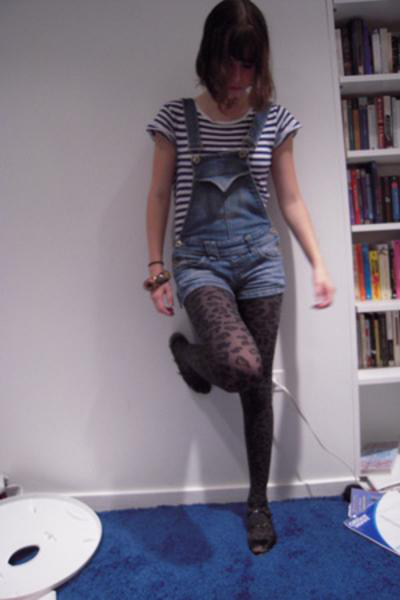

2
http://images2.chictopia.com//photos/thefashbot/3613535083/3613535083_400.jpg


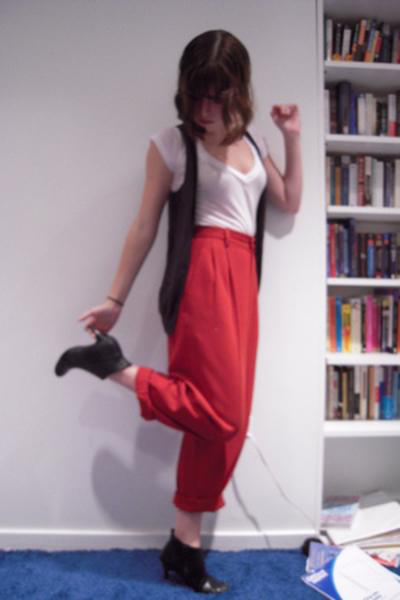

3
http://images2.chictopia.com//photos/thefashbot/3613535083/3420751783/3420751783_400.jpg


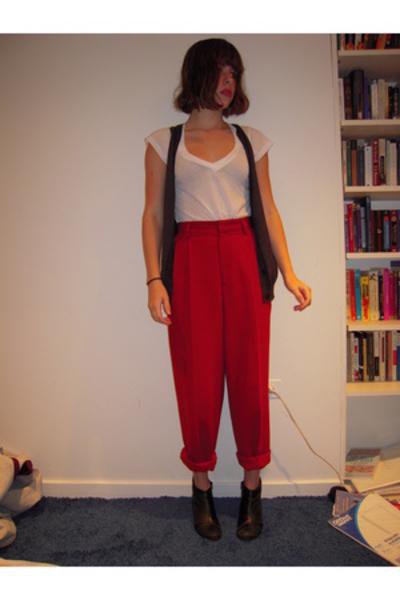

4
http://images2.chictopia.com//photos/thefashbot/10902372197/10902372197_400.jpg


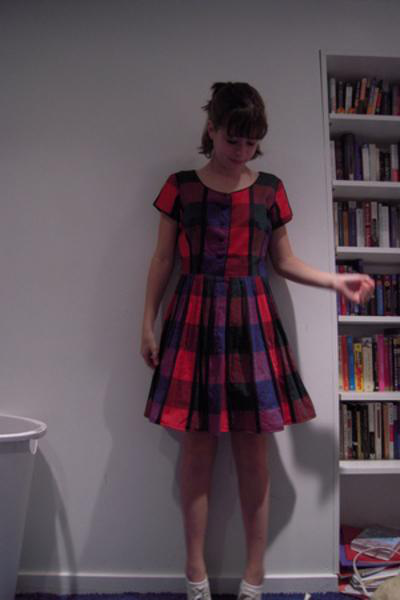

5
http://images2.chictopia.com//photos/thefashbot/4328323416/4328323416_400.jpg


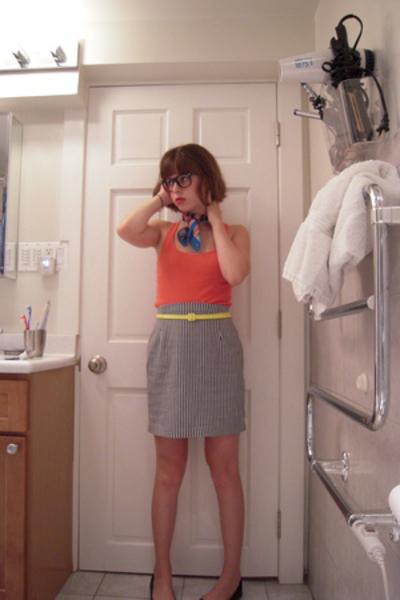

6
http://images2.chictopia.com//photos/thefashbot/3846669952/3846669952_400.jpg


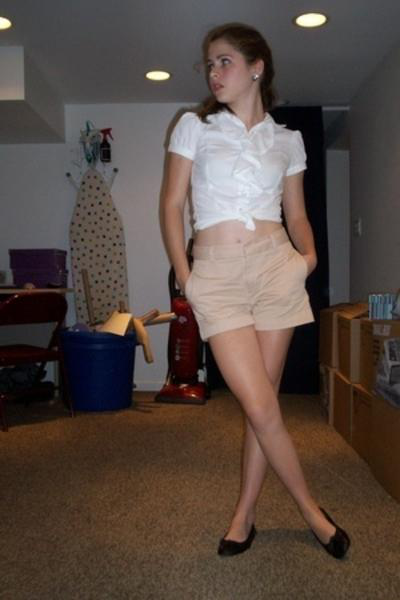

7
http://images2.chictopia.com//photos/thefashbot/3846669952/9248053763/9248053763_400.jpg


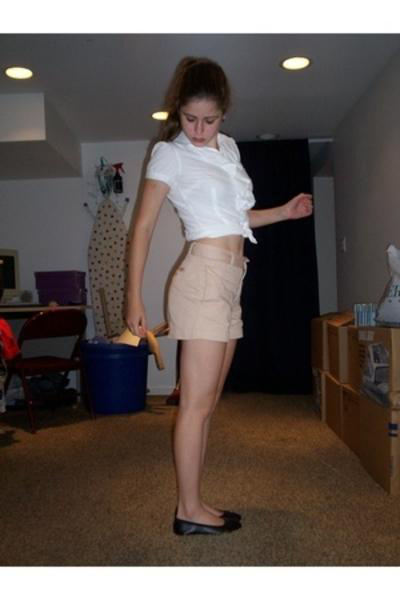

8
http://images2.chictopia.com//photos/thefashbot/5904281257/5904281257_400.jpg


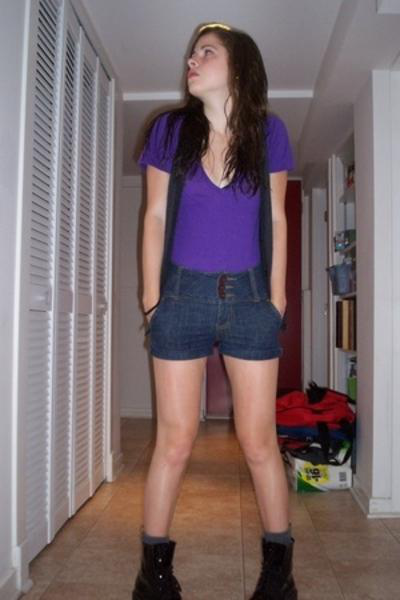

9
http://images2.chictopia.com//photos/thefashbot/5904281257/6406208724/6406208724_400.jpg


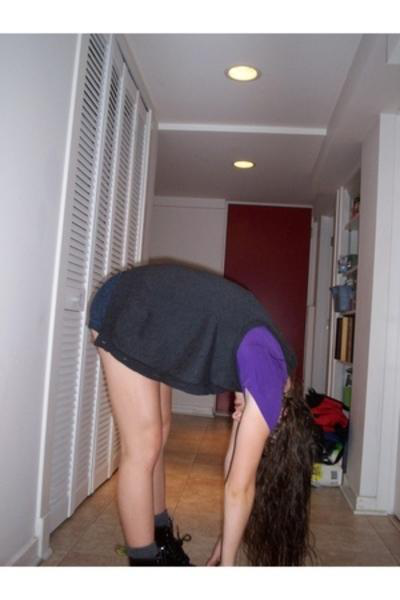

10
http://images2.chictopia.com//photos/homme/5747766283/5747766283_400.jpg


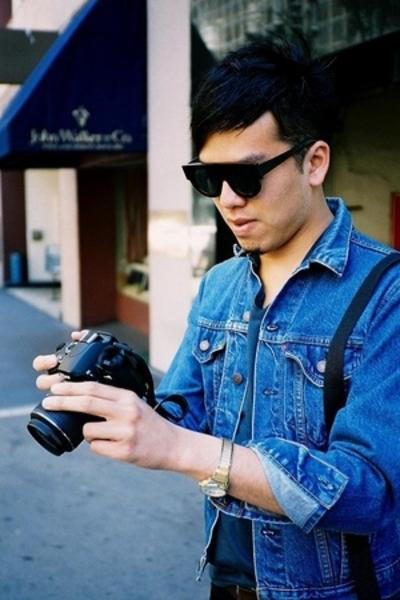

In [64]:
# This part of the code is adopted from the example_usage notebook 
# https://bit.ly/3kxRN5d

for i in range(10):
    photo = photos.iloc[i]
    print(photo.id)
    print(photo.url)
    display(photo_data[photo.id])

<hr style="border-top: 5px solid black; margin-top: 1px; margin-bottom: 1px"></hr>

# <span style='background :red' > Step 5: Do Some Fun Extra-Analysis with Charts 📊 </span> 


# <span style='background :pink' > ⬆️ LEFT OFF ABOVE ⬆️  </span> 

## <span style='background :orange' > Get Top-Level Counts of Combined Train 🚊  File & Classes Dict 📚 </span> 

In [ ]:
# In the Train data:
# ClassId corresponds to the category ID
# Each row in train contains a category label & multiple attribute labels

train_df[['ClassId','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['ClassId']).count().merge(categories_notNull_df,how='left',left_on='ClassId',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_categories')

### <span style='background :yellow' > Visualize entire distribution of supercategory categories </span> 

In [ ]:
train_df[['ClassId','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['ClassId']).count().merge(categories_notNull_df,how='left',left_on='ClassId',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('supercategory_categories').plot(kind='barh',y='counts_',use_index=True)

### <span style='background :yellow' > Visualize top 15 categories by supercategory count</span> 

In [ ]:
train_df[['ClassId','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['ClassId']).count().merge(categories_notNull_df,how='left',left_on='ClassId',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('supercategory_categories').iloc[:15].plot(kind='barh',y='counts_',use_index=True)

### <span style='background :yellow' > Visualize entire distribution of fine category (not super category) count </span> 

In [ ]:
train_df[['ClassId','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['ClassId']).count().merge(categories_notNull_df,how='left',left_on='ClassId',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_categories').plot(kind='barh',y='counts_',use_index=True)

### <span style='background :yellow' > Visualize top 15 of fine category (not super category) count </span> 

In [ ]:
train_df[['ClassId','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['ClassId']).count().merge(categories_notNull_df,how='left',left_on='ClassId',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_categories').iloc[:15].plot(kind='barh',y='counts_',use_index=True)

## <span style='background :orange' > Get Top-Level Counts of Combined Train 🚊  File & Attributes Dict 📚 </span> 

### <span style='background :yellow' > Select out columns to start analysis of attributes</span> 

In [ ]:
# Remember: The same image is represented multiple times with a unique ClassId 
# (aka one image can have multiple items of clothing) and each ClassId (item of clothing)
# can have multiple attributes (details like tpye of fabric, buttons, etc)
# This is why the AttributesIds column has a list of values

train_with_attributes = train_df[['ImageId','ClassId','AttributesIds']]
train_with_attributes

### <span style='background :yellow' > Explode out attributes to make a long train_attributes dataframe </span> 

In [ ]:
# Not all images have associated detailed attributes 
# If we just try to explode out the NaN values, we'll get an error
# So we need to convert the AttributesIds into a list of values (str)
# such that we can then encapsulate as a list, use pd.explode, 
# and then recast as int so we can merge on the indices.
# Phew!

train_with_attributes['AttributesIds'] = train_with_attributes['AttributesIds'].replace(np.nan,-1000).astype(str)
train_with_attributes['AttributesIds'] = train_with_attributes['AttributesIds'].apply(lambda x: list(x.split(",")))

train_with_attributes_long = train_with_attributes.explode('AttributesIds')
train_with_attributes_long['AttributesIds'] = train_with_attributes_long['AttributesIds'].astype(int)
train_with_attributes_long

In [ ]:
# Now we have a count of number of times (not images but occurrences) of the attributes
train_with_attributes_long[['AttributesIds','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['AttributesIds']).count().merge(attributes_df,how='left',left_on='AttributesIds',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_attributes')

In [ ]:
# This should be an ugly mess of a chart -- long tail but we also have a bunch of the 
# top-level categories being repeated
train_with_attributes_long[['AttributesIds','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['AttributesIds']).count().merge(attributes_df,how='left',left_on='AttributesIds',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_attributes').plot(kind='barh',y='counts_',use_index=True)

In [ ]:
# Grabbing just the first 15, we see there are a bunch of occurrences of NaN
# This isnt surprising as the dataset creators described how only a subset of the original data
# had additional detailed attributes information.
train_with_attributes_long[['AttributesIds','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['AttributesIds']).count().merge(attributes_df,how='left',left_on='AttributesIds',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_attributes').iloc[:15].plot(kind='barh',y='counts_',use_index=True)

In [ ]:
# Ignoring Nan, checking out the top 30 attributes
train_with_attributes_long[['AttributesIds','ImageId']].rename(columns={'ImageId':'counts_'}).groupby(['AttributesIds']).count().merge(attributes_df,how='left',left_on='AttributesIds',right_index=True).reset_index().sort_values('counts_',ascending=False).set_index('name_attributes').iloc[1:30].plot(kind='barh',y='counts_',use_index=True)